In [1]:
import tensorflow as tf
import os
import splitfolders as sf
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import roc_curve, roc_auc_score
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, concatenate, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
train_dir = r'A:\AI DB\LSPD\Videos\photos_from_videos_pret\train'
validation_dir = r'A:\AI DB\LSPD\Videos\photos_from_videos_pret\val'
test_dir = r'A:\AI DB\LSPD\Videos\photos_from_videos_pret\test'

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 256

In [3]:
# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5] 
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,                                          
    seed=10,
    class_mode='binary'
)

Found 430877 images belonging to 2 classes.
Found 23937 images belonging to 2 classes.
Found 23939 images belonging to 2 classes.


In [9]:
# Load the model
model_path = r'A:\AI DB\LSPD\models\3Modal.keras'
model = load_model(model_path)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3large (Functional)  (None, 960)          2996352     ['input_layer[0][0]']            
                                                                                                  
 densenet169 (Functional)       (None, 1664)         12642880    ['input_layer[0][0]']            
                                                                                                  
 inception_v3 (Functional)      (None, 2048)         21802784    ['input_layer[0][0]']      

In [10]:
# Make predictions
ypred = model.predict(test_generator)

94/94 [==============================] - 125s 1s/step


Classification Report:
               precision    recall  f1-score   support

           0     0.7184    0.8692    0.7866      9762
           1     0.8947    0.7654    0.8250     14177

    accuracy                         0.8077     23939
   macro avg     0.8066    0.8173    0.8058     23939
weighted avg     0.8228    0.8077    0.8094     23939



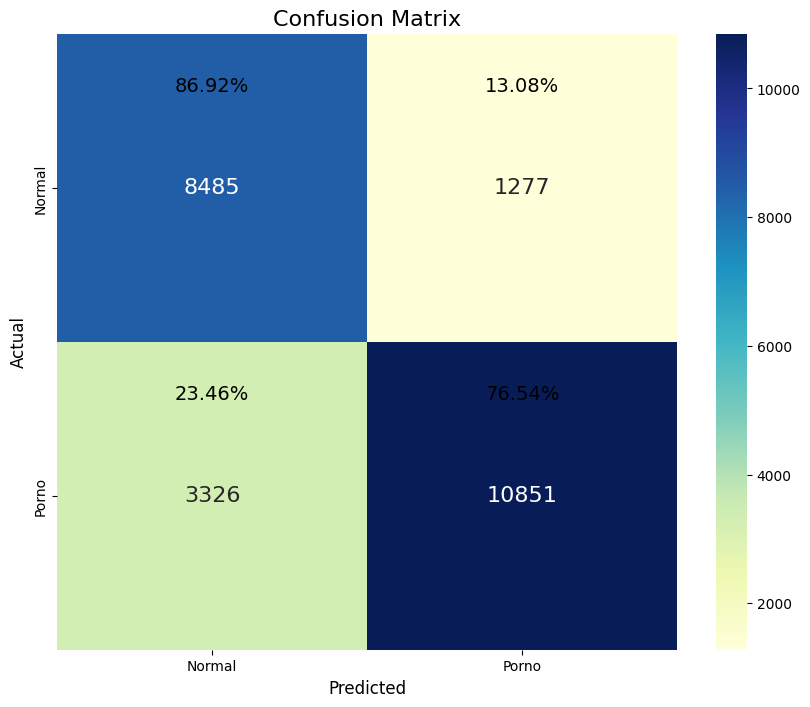

Accuracy Score: 0.8077
F1 Score: 0.8250


In [12]:
# Convert predicted probabilities to binary predictions
threshold = 0.5
y_pred_classes = (ypred > threshold).astype(int)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:\n", cr)

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))

In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# Set up callbacks
checkpoint = ModelCheckpoint(r'A:\AI DB\LSPD\models\3ModaforImagesFromVideos.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/5
1683/1683 [==============================] - 6549s 4s/step - loss: 0.3435 - accuracy: 0.8521 - val_loss: 0.2701 - val_accuracy: 0.8898
Epoch 2/5
1683/1683 [==============================] - 5941s 4s/step - loss: 0.2947 - accuracy: 0.8772 - val_loss: 0.2480 - val_accuracy: 0.9004
Epoch 3/5
1683/1683 [==============================] - 5994s 4s/step - loss: 0.2780 - accuracy: 0.8851 - val_loss: 0.2349 - val_accuracy: 0.9060
Epoch 4/5
1683/1683 [==============================] - 5985s 4s/step - loss: 0.2672 - accuracy: 0.8897 - val_loss: 0.2258 - val_accuracy: 0.9093
Epoch 5/5
1683/1683 [==============================] - 5901s 4s/step - loss: 0.2582 - accuracy: 0.8935 - val_loss: 0.2202 - val_accuracy: 0.9111


In [15]:
# Train the model
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    initial_epoch=4,
    epochs=8,
    callbacks=[checkpoint, early_stopping]
)

Epoch 5/8
1683/1683 [==============================] - 5920s 4s/step - loss: 0.2508 - accuracy: 0.8973 - val_loss: 0.2110 - val_accuracy: 0.9154
Epoch 6/8
1683/1683 [==============================] - 5906s 4s/step - loss: 0.2436 - accuracy: 0.9004 - val_loss: 0.2064 - val_accuracy: 0.9176
Epoch 7/8
1683/1683 [==============================] - 5903s 4s/step - loss: 0.2381 - accuracy: 0.9028 - val_loss: 0.2016 - val_accuracy: 0.9182
Epoch 8/8
1683/1683 [==============================] - 6166s 4s/step - loss: 0.2341 - accuracy: 0.9048 - val_loss: 0.1957 - val_accuracy: 0.9219


In [4]:
model=load_model(r'A:\AI DB\LSPD\models\3ModaforImagesFromVideos.keras')

In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
# Set up callbacks
checkpoint = ModelCheckpoint(r'A:\AI DB\LSPD\models\3ModaforImagesFromVideosV2.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')


In [8]:
history3 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    initial_epoch=10,
    epochs=15,
    callbacks=[checkpoint, early_stopping]
)

Epoch 11/15
1683/1683 [==============================] - 5997s 4s/step - loss: 0.2163 - accuracy: 0.9121 - val_loss: 0.1806 - val_accuracy: 0.9282
Epoch 12/15
1683/1683 [==============================] - 5958s 4s/step - loss: 0.2127 - accuracy: 0.9145 - val_loss: 0.1768 - val_accuracy: 0.9291
Epoch 13/15
1683/1683 [==============================] - 5912s 4s/step - loss: 0.2109 - accuracy: 0.9150 - val_loss: 0.1761 - val_accuracy: 0.9301
Epoch 14/15
1683/1683 [==============================] - 5871s 3s/step - loss: 0.2083 - accuracy: 0.9160 - val_loss: 0.1720 - val_accuracy: 0.9319
Epoch 15/15
1683/1683 [==============================] - 6070s 4s/step - loss: 0.2051 - accuracy: 0.9174 - val_loss: 0.1703 - val_accuracy: 0.9322


In [9]:
# Make predictions
ypred = model.predict(test_generator)

94/94 [==============================] - 183s 2s/step


Classification Report:
               precision    recall  f1-score   support

           0     0.9126    0.9297    0.9211      9762
           1     0.9510    0.9387    0.9448     14177

    accuracy                         0.9350     23939
   macro avg     0.9318    0.9342    0.9329     23939
weighted avg     0.9353    0.9350    0.9351     23939



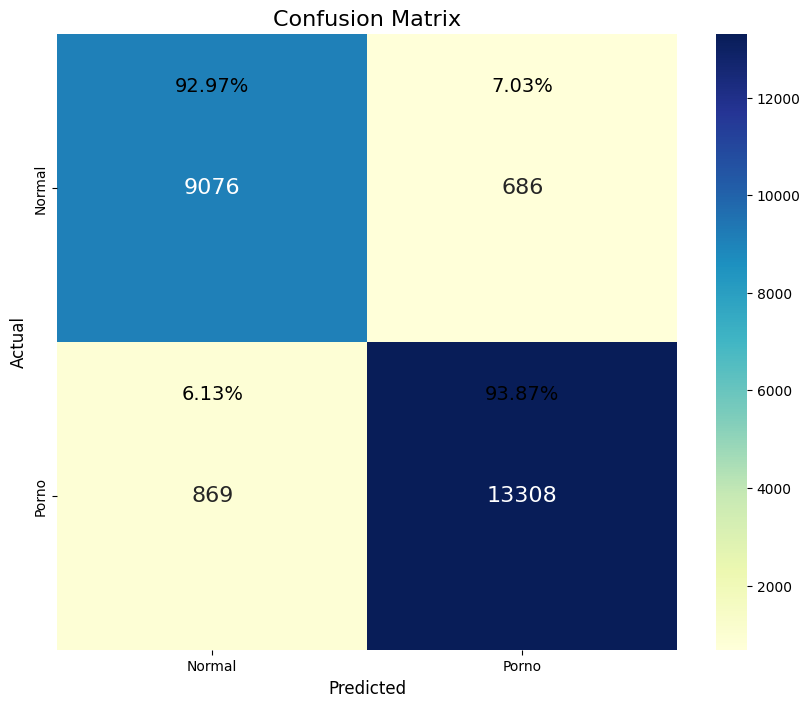

Accuracy Score: 0.9350
F1 Score: 0.9448


In [16]:
# Convert predicted probabilities to binary predictions
threshold = 0.5
y_pred_classes = (ypred > threshold).astype(int)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:\n", cr)

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))

In [16]:
# Make predictions
ypred = model.predict(test_generator)

94/94 [==============================] - 179s 2s/step


Classification Report:
               precision    recall  f1-score   support

           0     0.8970    0.9195    0.9081      9762
           1     0.9436    0.9273    0.9354     14177

    accuracy                         0.9241     23939
   macro avg     0.9203    0.9234    0.9217     23939
weighted avg     0.9246    0.9241    0.9242     23939



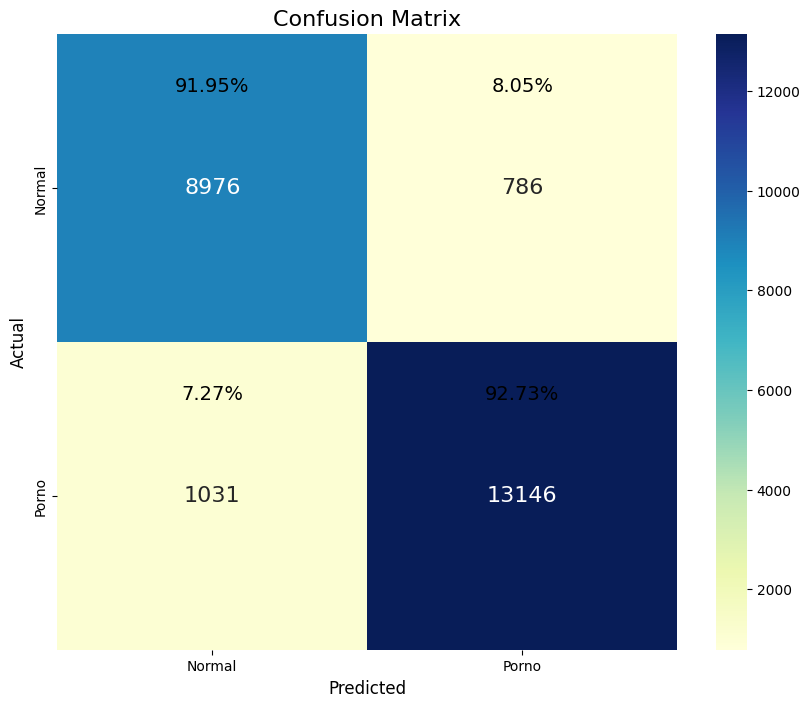

Accuracy Score: 0.9241
F1 Score: 0.9354


In [17]:
# Convert predicted probabilities to binary predictions
threshold = 0.5
y_pred_classes = (ypred > threshold).astype(int)

# Get actual classes
y_true_classes = test_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Generate a classification report
cr = classification_report(y_true_classes, y_pred_classes, digits=4)
print("Classification Report:\n", cr)

# Plot the confusion matrix with annotations positioned at the bottom
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='d', xticklabels=['Normal', 'Porno'], yticklabels=['Normal', 'Porno'], annot_kws={'size': 16})

# Add custom annotations at the bottom of each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.2, '{:.2f}%'.format(cm_normalized[i, j] * 100), ha='center', va='bottom', color='black', fontsize=14)

plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy Score:", format(accuracy, '.4f'))

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes)
print("F1 Score:", format(f1, '.4f'))